In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('Weather Data.csv', index_col='Date/Time', parse_dates=['Date/Time']).dropna()
df.head()

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
Date/Time,,,,,,,
2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,Fog
2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,Fog


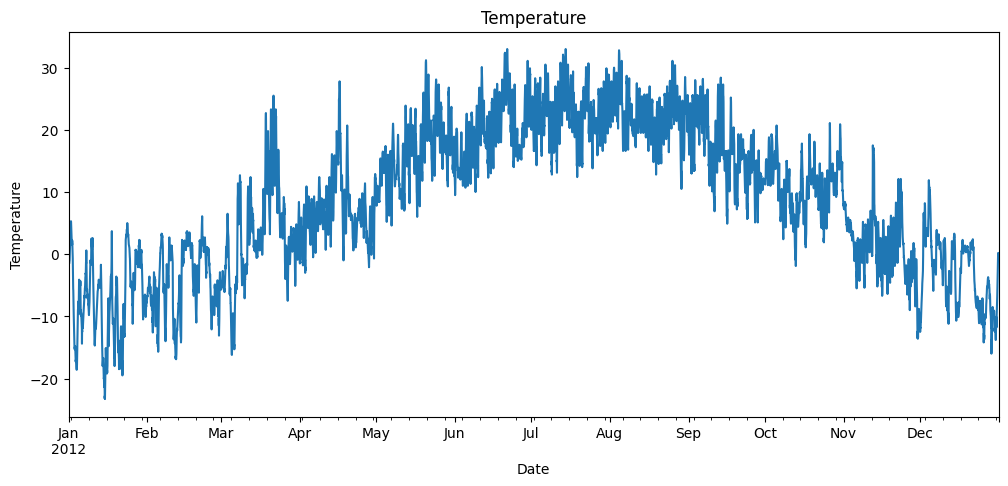

In [3]:
df['Temp_C'].plot(figsize=(12, 5))
plt.title('Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

In [4]:
data = df['Temp_C'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [5]:
sequence_length = 30

In [6]:
# Prepare data for training
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i+sequence_length, 0])
    y.append(data_scaled[i+sequence_length, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  #(number of samples, sequence length=30, number of features=1)
X.shape

(8754, 30, 1)

In [7]:
split = int(0.8 * len(data_scaled))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [8]:
# LSTM model
model = Sequential()
model.add(LSTM(units=32, input_shape=(X.shape[1], X.shape[2]), activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='adam')

In [9]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=34, validation_split=0.1, verbose=1)

# predictions
test_predictions_scaled = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions_scaled).flatten()

Epoch 1/50

186/186 [==============================] - 5s 15ms/step - loss: 0.0366 - val_loss: 0.0019
Epoch 2/50
186/186 [==============================] - 3s 14ms/step - loss: 0.0019 - val_loss: 8.5853e-04
Epoch 3/50
186/186 [==============================] - 3s 14ms/step - loss: 8.3431e-04 - val_loss: 6.3724e-04
Epoch 4/50
186/186 [==============================] - 2s 13ms/step - loss: 6.5316e-04 - val_loss: 5.3212e-04
Epoch 5/50
186/186 [==============================] - 2s 13ms/step - loss: 5.6526e-04 - val_loss: 4.4762e-04
Epoch 6/50
186/186 [==============================] - 2s 12ms/step - loss: 4.9524e-04 - val_loss: 4.7173e-04
Epoch 7/50
186/186 [==============================] - 2s 11ms/step - loss: 4.6624e-04 - val_loss: 3.9752e-04
Epoch 8/50
186/186 [==============================] - 2s 12ms/step - loss: 4.2316e-04 - val_loss: 3.4396e-04
Epoch 9/50
186/186 [==============================] - 2s 11ms/step - loss: 4.3824e-04 - val_loss: 3.3291e-04
Epoch 10/50
186/186 [=========

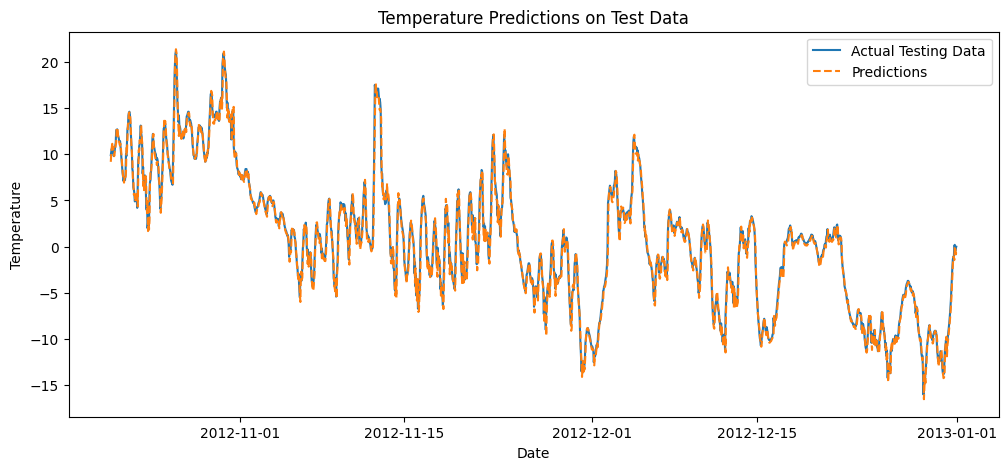

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(df.index[split+sequence_length:], df['Temp_C'][split+sequence_length:], label='Actual Testing Data')
plt.plot(df.index[split+sequence_length:], test_predictions, label='Predictions', linestyle='dashed')
plt.title('Temperature Predictions on Test Data')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

test_actual_temps = df['Temp_C'][split + sequence_length:].values
test_mse = mean_squared_error(test_actual_temps, test_predictions)
test_rmse = sqrt(test_mse)

print(f"Root Mean Squared Error (RMSE) on Test Data: {test_rmse}")


Root Mean Squared Error (RMSE) on Test Data: 0.8178966616524105


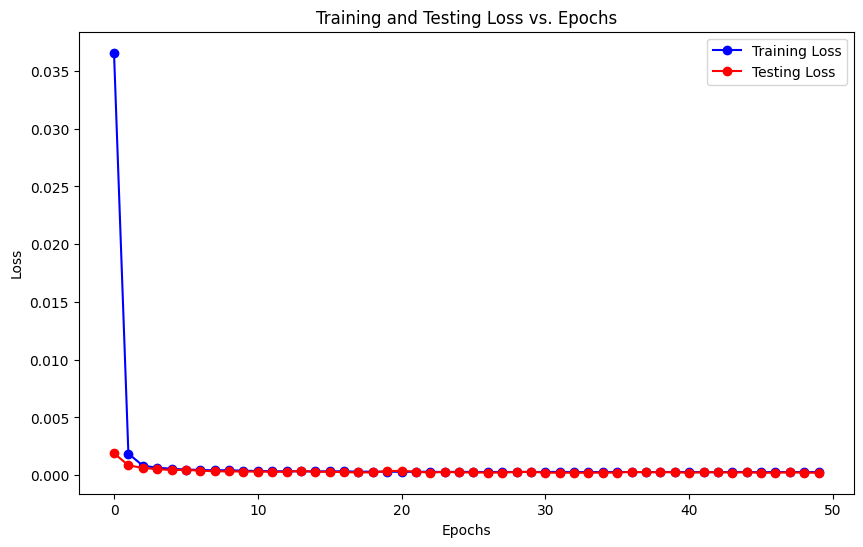

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], 'bo-', label='Training Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Testing Loss')
plt.title('Training and Testing Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
